In [ ]:
import numpy as np
import pickle
import cv2
import tensorflow
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d emmarex/plantdisease

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 99% 649M/658M [00:12<00:00, 123MB/s]
100% 658M/658M [00:12<00:00, 55.1MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/plantdisease.zip', 'r')
zip_ref.extractall('/content/input')
zip_ref.close()

In [ ]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/content/input/plantvillage'
width=256
height=256
depth=3

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")

            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Image loading completed


In [ ]:
image_size = len(image_list)
print(image_size)

2952


In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [ ]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print(np_image_list)

[[[[0.4355 0.422  0.4934]
   [0.4133 0.4    0.4712]
   [0.4622 0.449  0.52  ]
   ...
   [0.569  0.5645 0.6357]
   [0.422  0.4177 0.4888]
   [0.4312 0.4268 0.4978]]

  [[0.573  0.56   0.6313]
   [0.48   0.4666 0.5376]
   [0.4045 0.391  0.4622]
   ...
   [0.4443 0.44   0.511 ]
   [0.3733 0.369  0.44  ]
   [0.4    0.3955 0.4666]]

  [[0.4978 0.4844 0.5557]
   [0.44   0.4268 0.4978]
   [0.4133 0.4    0.4712]
   ...
   [0.369  0.3645 0.4355]
   [0.36   0.3555 0.4268]
   [0.4045 0.4    0.4712]]

  ...

  [[0.7866 0.769  0.818 ]
   [0.818  0.8    0.849 ]
   [0.8223 0.8047 0.8535]
   ...
   [0.7646 0.76   0.8047]
   [0.778  0.7734 0.818 ]
   [0.8047 0.8    0.844 ]]

  [[0.76   0.742  0.791 ]
   [0.8    0.782  0.831 ]
   [0.8047 0.7866 0.8354]
   ...
   [0.7554 0.751  0.7954]
   [0.7734 0.769  0.8135]
   [0.8047 0.8    0.844 ]]

  [[0.7153 0.6978 0.7466]
   [0.7646 0.7466 0.7954]
   [0.782  0.7646 0.8135]
   ...
   [0.76   0.7554 0.8   ]
   [0.778  0.7734 0.818 ]
   [0.809  0.8047 0.849 ]]]


 

In [ ]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Spliting data to train, test


In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest")

In [ ]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1

model.add(Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=inputShape))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Replace 'n_classes' with the number of output classes
model.add(Dense(n_classes, activation="softmax"))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 64)      2

In [ ]:
# opt = Adam(learning_rate=INIT_LR)
# distribution
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [ ]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/25
73/73 [==============================] - 64s 680ms/step - loss: 0.6983 - accuracy: 0.2559 - val_loss: 0.6459 - val_accuracy: 0.0592
Epoch 2/25
73/73 [==============================] - 44s 596ms/step - loss: 0.2645 - accuracy: 0.4294 - val_loss: 0.5922 - val_accuracy: 0.0626
Epoch 3/25
73/73 [==============================] - 43s 593ms/step - loss: 0.1484 - accuracy: 0.6170 - val_loss: 0.8665 - val_accuracy: 0.0778
Epoch 4/25
73/73 [==============================] - 44s 604ms/step - loss: 0.1265 - accuracy: 0.6745 - val_loss: 0.5885 - val_accuracy: 0.1100
Epoch 5/25
73/73 [==============================] - 44s 606ms/step - loss: 0.1104 - accuracy: 0.7274 - val_loss: 0.5892 - val_accuracy: 0.1117
Epoch 6/25
73/73 [==============================] - 45s 605ms/step - loss: 0.0947 - accuracy: 0.7621 - val_loss: 0.7255 - val_accuracy: 0.0998
Epoch 7/25
73/73 [==============================] - 44s 605ms/step - loss: 0.0894 - accuracy: 0.7836 - val_loss: 0.4702 - val_accuracy: 0.1675

In [ ]:
print(history.params)

{'verbose': 1, 'epochs': 25, 'steps': 73}


In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


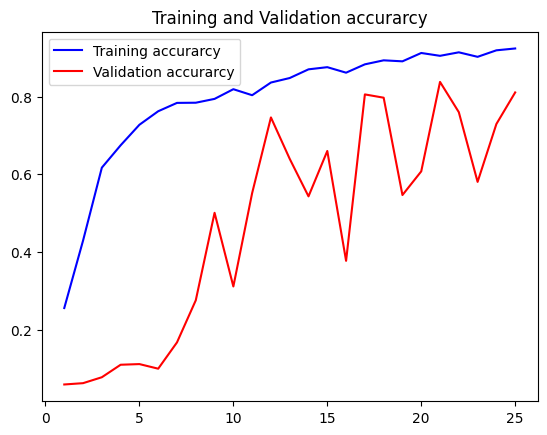

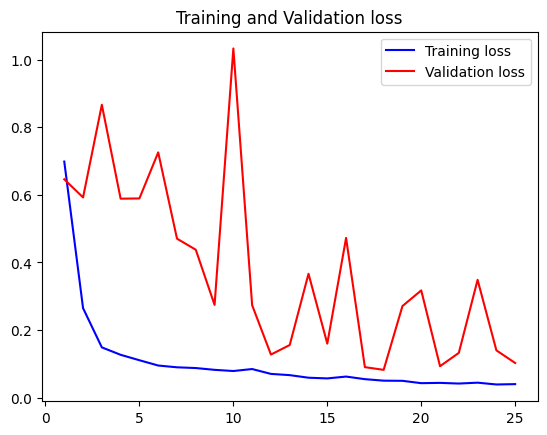

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
print("[INFO] Calculating model accuracy")
loaded_model = load_model("leaf_model.h5")
scores = loaded_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
19/19 [==============================] - 1s 30ms/step - loss: 0.1022 - accuracy: 0.8105
Test Accuracy: 81.04906678199768


In [ ]:
print("[INFO] Saving model...")
# pickle.dump(model,open('cnn_model.pkl', 'wb'))
model.save("cnn_model")
model.save("leaf_model.h5")

[INFO] Saving model...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save("plant_disease.keras")

In [ ]:
loaded_model = load_model("plant_disease.keras")

In [ ]:

!zip -r '/content/my_model.zip' '/content/cnn_model'

  adding: content/cnn_model/ (stored 0%)
  adding: content/cnn_model/assets/ (stored 0%)
  adding: content/cnn_model/saved_model.pb (deflated 89%)
  adding: content/cnn_model/fingerprint.pb (stored 0%)
  adding: content/cnn_model/variables/ (stored 0%)
  adding: content/cnn_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/cnn_model/variables/variables.index (deflated 71%)
  adding: content/cnn_model/keras_metadata.pb (deflated 94%)


In [ ]:
# image_dir="/content/input/PlantVillage"

# folder_names = listdir(image_dir)
# print(images_dir)

# for folder_name in folder_names:
  # print(folder_name)
  # images = listdir(f"{image_dir}/{folder_name}")
  # print(folder_name)
  # print(images)

# print(image_dir)
# folder_name = "Potato__Early_blight"
# images = listdir(f"/content/input/PlantVillage/Tomato_Late_blight")
# print(folder_name)
# print(images)
image_location = f"/content/input/PlantVillage/Potato___Early_blight/02578b86-b234-4ac0-9bc3-691b5610e2bf___RS_Early.B 7562.JPG"
# print(images[5])
im=convert_image_to_array(image_location)
# print(im)
np_image_li = np.array(im, dtype=np.float16) / 255.0
# print(np_image_li)
npp_image = np.expand_dims(np_image_li, axis=0)
# print(npp_image)

In [ ]:
result = loaded_model.predict(npp_image)

print(result)

1/1 [==============================] - 1s 595ms/step
[[1.4225378e-07 1.8630449e-07 9.9998522e-01 1.6820458e-07 6.6533334e-10
  1.8945638e-08 1.5978602e-06 4.4142794e-06 2.3361555e-09 6.8415609e-08
  5.4930798e-09 8.9901748e-09 5.3800462e-09 2.4140107e-10 8.1238340e-06]]


In [ ]:
itemindex = np.where(result==np.max(result))
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

probability:0.9999852
Potato___Early_blight
